In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pydicom
import cv2
import pandas as pd
import numpy as np
from glob import glob
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import sys

from tqdm import tqdm
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")
torch.cuda.empty_cache()

In [3]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
TEST_ROOT = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'
TEST_SERIES = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv'
TRAIN_ROOT = "./train_images"
TRAIN_ROOT = f"G:/rsna-abdominal-2023/reduced_512_tickness_5/"
TRAIN_ROOT = f"G:/rsna-2023-abdominal-trauma-detection/cropped_images_3ch/"
VOLUME = (128, 64, 64)

BATCH_SIZE = 32

VOLUME = (128, 128, 128)

VOLUME = (128, 224, 224)
VOLUME = (128, 256, 256)
WINDOW_STEP = 2
# Odd Number Only
WINDOW_WIDTH = 3
PAD_ENDING = True

SLICE_NUM = (128-1)//2 + 1

TARGET_COLS  = [
    "bowel_healthy","bowel_injury","extravasation_healthy", "extravasation_injury",
    "kidney_healthy", "kidney_low", "kidney_high",
    "liver_healthy", "liver_low", "liver_high",
    "spleen_healthy", "spleen_low", "spleen_high",
]
# TARGET_COLS  = [
#     "bowel_injury", "extravasation_injury",
#     "kidney_healthy", "kidney_low", "kidney_high",
#     "liver_healthy", "liver_low", "liver_high",
#     "spleen_healthy", "spleen_low", "spleen_high",
# ]
# organ_name = "eleven"
organ_name = "all"
# TARGET_COLS  = [
#     "bowel_healthy","bowel_injury","extravasation_healthy", "extravasation_injury"]

# TARGET_COLS  = ["liver_healthy","liver_low","liver_high"]
# organ_name = "liver"
version="1010bal"
seg_cls = ["5"]
# folder = "_3ch"
folder = "D:/cropped_organs_npy"
folder = "./tensor_6ch"
folder = "D:/tensor_6ch"
# TARGET_COLS  = ["kidney_low","kidney_high"]
# organ_name = "lkidney"
# version=1005
# seg_cls = ["3"]
# folder = "_3ch"

# TARGET_COLS  = ["spleen_healthy","spleen_low","spleen_high"]
# organ_name = "spleen"
# version=1003
# seg_cls = ["2"]
# folder = "_3ch"
print(organ_name,seg_cls,TARGET_COLS,version,folder)

all ['5'] ['bowel_healthy', 'bowel_injury', 'extravasation_healthy', 'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high'] 1010bal D:/tensor_6ch


In [6]:
SLICE_NUM

64

In [7]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        resnet = torchvision.models.resnet18()
        resnet.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        self.ltsm = nn.LSTM(input_size=512, hidden_size=128, batch_first=True)
        # self.fc = nn.Linear(in_features=128*SLICE_NUM, out_features=len(TARGET_COLS))
        self.fc = nn.Linear(in_features=128*VOLUME[0], out_features=len(TARGET_COLS))
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        # x = x.view(batch_size * SLICE_NUM, WINDOW_WIDTH, VOLUME[1], VOLUME[2])
        x = x.view(batch_size * VOLUME[0], 6, VOLUME[1], VOLUME[2])
        x = self.backbone(x)
        # x = x.view(batch_size, SLICE_NUM, -1) 
        x = x.view(batch_size, VOLUME[0], -1) 
        
        x, _ = self.ltsm(x)
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc(x)
        
        return x

In [8]:
model = Net().to(device)
sum(p.numel() for p in model.parameters() if p.requires_grad)
# model.load_state_dict(torch.load('/kaggle/input/rsna-2-5d-resnet-ltsm/model.pt')['model'])
# model.eval()
model = model.train()

In [9]:
train_df = pd.read_csv("./train.csv")
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in glob("./train_images/*/*")}
s_ids = s_id_p_id.keys()

p_ids = [int(s_id_p_id[x]) for x in s_ids]
p_s_df = pd.DataFrame({"series_id":s_ids,"patient_id":p_ids})
train_df = p_s_df.merge(train_df,on="patient_id",how="left")


In [10]:
train_df.series_id.values

array(['21057', '51033', '18667', ..., '40214', '40466', '10806'],
      dtype=object)

In [11]:
# folder = "D:/cropped_organs_npy"

In [12]:
train_df[train_df.series_id=="9673"]

,series_id,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
1486,9673,28211,1,0,1,0,1,0,0,1,0,0,1,0,0,0


In [13]:
print("before", len(train_df))
existing = [str(x.split("_")[-1].split(".")[0]) for x in glob(f"D:/tensor_6ch/*")]
train_df = train_df[train_df.series_id.isin(existing)].reset_index(drop=True)
print("after", len(train_df))

before 4711
after 4450


In [14]:
from sklearn.model_selection import KFold, GroupKFold

gkf = KFold(n_splits=5)
for i, (train_index, val_index) in enumerate(gkf.split(train_df, groups=train_df["patient_id"])):
    train_df.loc[val_index,"fold"]=i
trn_df = train_df[train_df.fold!=0].reset_index(drop=True)
val_df = train_df[train_df.fold==0].reset_index(drop=True)
for col in TARGET_COLS:
    print(col, np.sum(trn_df[col].values),len(trn_df),np.sum(val_df[col].values),len(val_df))
trn_df = train_df

bowel_healthy 3499 3560 870 890
bowel_injury 61 3560 20 890
extravasation_healthy 3384 3560 847 890
extravasation_injury 176 3560 43 890
kidney_healthy 3421 3560 848 890
kidney_low 96 3560 27 890
kidney_high 43 3560 15 890
liver_healthy 3288 3560 817 890
liver_low 231 3560 55 890
liver_high 41 3560 18 890
spleen_healthy 3244 3560 803 890
spleen_low 197 3560 56 890
spleen_high 119 3560 31 890


In [30]:
trn_df[trn_df["bowel_injury"]==1]

,series_id,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,fold
6,37324,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0.0
7,46839,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0.0
63,34169,10929,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0.0
83,24276,11335,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0.0
84,39434,11335,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,49474,7482,0,1,1,0,1,0,0,1,0,0,1,0,0,1,4.0
4321,11921,820,0,1,0,1,1,0,0,1,0,0,1,0,0,1,4.0
4322,38809,820,0,1,0,1,1,0,0,1,0,0,1,0,0,1,4.0
4351,38440,8684,0,1,1,0,1,0,0,1,0,0,1,0,0,1,4.0


In [33]:
pos_df = trn_df[trn_df.bowel_healthy==1]
pos_df = pos_df[pos_df.extravasation_healthy==1]
pos_df = pos_df[pos_df.kidney_healthy==1]
pos_df = pos_df[pos_df.liver_healthy==1]
pos_df = pos_df[pos_df.spleen_healthy==1]
neg_df = trn_df[~trn_df.series_id.isin(pos_df.series_id.values)]
trn_df = pd.concat([pos_df.iloc[np.random.choice(len(pos_df),int(len(neg_df)*1.3))],\
                    neg_df],axis=0)
pos_df.shape,neg_df.shape,trn_df.shape

((3378, 17), (1072, 17), (2465, 17))

In [38]:
def dicom_to_image(dcm):
    
    pixel_array = dcm.pixel_array
    
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        
    if dcm.PhotometricInterpretation == "MONOCHROME1":
        pixel_array = 1 - pixel_array
        
    intercept = dcm.RescaleIntercept
    slope = dcm.RescaleSlope
    pixel_array = pixel_array * slope + intercept
    
    window_center = 50
    window_width = 400
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    pixel_array = pixel_array.copy()
    pixel_array[pixel_array < img_min] = img_min
    pixel_array[pixel_array > img_max] = img_max
    
    pixel_array = (pixel_array - img_min)/(img_max-img_min)
        
    return pixel_array

In [39]:
# test_series = pd.read_csv(TEST_SERIES)
train_df.shape

(4450, 17)

In [36]:

# df[df.patient_id==10004].loc[0][TARGET_COLS].values

In [40]:
TRAIN_ROOT


'G:/rsna-2023-abdominal-trauma-detection/cropped_images_3ch/'

In [41]:
import pydicom as dicom

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data


In [42]:
def expand_array(input_mask):
    added1 = added2 = added3 = added4 = np.zeros(input_mask.shape)
    added1[:,1:] = input_mask[:,:-1]
    added2[:,:-1] = input_mask[:,1:]
    added3[1:,:] = input_mask[:-1,:]
    added3[:-1,:] = input_mask[1:,:]
    return added1+added2+added3+added4+input_mask>0

In [43]:
class TrainDataset(Dataset):
    
    def __init__(self, df):
        self.train_df = df

    def __len__(self):
        return len(self.train_df)
    
    def get_slices(self, volume):
        slices = []
        
        v = torch.flip(volume, dims=[0])
        
        margin = (WINDOW_WIDTH-1)//2
        for i in range(margin, VOLUME[0], WINDOW_STEP):
            if(i+margin < VOLUME[0]):
                sl = v[(i-margin):(i+margin+1)]
            else:
                if(PAD_ENDING):
                    sl = torch.zeros((WINDOW_WIDTH, VOLUME[1], VOLUME[2], 2))
                    copy_number = VOLUME[0] - i + margin
                    sl[:copy_number] = v[i-margin:VOLUME[0]]
                else:
                    break
            sl = torch.flip(sl, dims=[0])
            slices.append(sl)
                    
        return slices
    

    def make_interpolate_tensor(self,input_arr):
        tensor = torch.Tensor(input_arr.astype(np.float32)).to(torch.float32)
        tensor = tensor.unsqueeze(dim=0).unsqueeze(dim=0)
        tensor = F.interpolate(tensor, [VOLUME[0], VOLUME[1], VOLUME[2]]).squeeze()
        return tensor

    def __getitem__(self, idx):
        row = self.train_df.iloc[idx]
        pid = int(row["patient_id"])
        sid = int(row["series_id"])
        
        img = []
        mask_list = []
        # for ii in range(1,6):
        #     npy_path = f"{folder}/{pid}_{sid}_{ii}.npy"
        #     if not os.path.exists(npy_path):
        #         print(npy_path,"doesn't exists")
        #     mask_arr = np.load(npy_path).transpose(1,0,2,3)
        #     # print("npy file shape",mask_arr.shape)
        #     if not len(img):
        #         img = mask_arr[0]
        #     print(pid,sid,ii, mask_arr.shape)
        #     mask_list.append(mask_arr[1])
        
        # tensor_6ch = torch.Tensor(np.array([img]+mask_list).astype(np.float32))
        print("loading",pid,sid)
        tensor_6ch = torch.Tensor(np.load(f"{folder}/{pid}_{sid}.npy"))
        # print(tensor_6ch.shape)
        tensor_6ch = torch.transpose(tensor_6ch,0,1).to(torch.float32)

        return sid, tensor_6ch, \
            torch.from_numpy(row[TARGET_COLS].values.astype(np.float32)).to(torch.float32)

In [44]:
train_dataset = TrainDataset(train_df)#[train_df.patient_id==11217])#[train_df.series_id=="29964"])
len(train_dataset)

4450

In [45]:
# for i in tqdm(range(len(train_dataset))):
#     try:
#         xx = (train_dataset[i][0])
#     except:
#         print(train_dataset[i][0])
    

In [ ]:
print(np.load("D:/tensor_6ch/2821"))

4450
loading 46202 32122
loading 46202 32122
32122 torch.Size([128, 6, 256, 256])
[0.] torch.Size([256, 256]) tensor(0.9955) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(0.9346) tensor(0.) tensor(1.) tensor(0.)
[0. 1.] torch.Size([256, 256]) tensor(0.9666) tensor(0.) tensor(1.) tensor(0.)
[0. 1.] torch.Size([256, 256]) tensor(1.) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(0.9210) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(0.9682) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(1.) tensor(0.) tensor(1.) tensor(0.)
[0. 1.] torch.Size([256, 256]) tensor(0.9778) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(0.9986) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(1.) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(1.) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([256, 256]) tensor(1.) tensor(0.) tensor(1.) tensor(0.)
[0.] torch.Size([

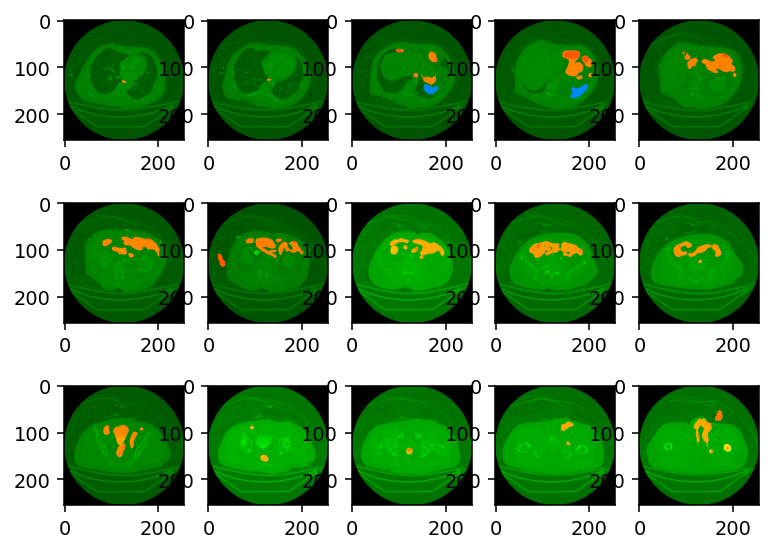

In [46]:
print(len(train_dataset))

import matplotlib
matplotlib.rcParams['figure.dpi'] = 140
show_id = np.random.randint(0,len(train_dataset))
show_img = train_dataset[show_id][1]
print(train_dataset[show_id][0],show_img.shape)
for ii in range(15):
    show_slice = int(show_img.shape[0]/15*ii)
    # print(show_img.shape,show_img.max(),show_img.min())
    show_mask = show_img[show_slice][5] # can be choose from 1 - 5
    show_jpg = show_img[show_slice][0]
    show_mask2 = show_img[show_slice][2] # can be choose from 1 - 5
    print(np.unique(show_mask2),show_mask.shape,show_jpg.max(),show_jpg.min(),show_mask.max(),show_mask.min())
    # print(show_img)
    axs = plt.subplot(3,5,ii+1);#axs.set_figheight(15)
    plt.imshow(np.stack([show_mask,show_jpg,show_mask2],axis=2).clip(0,255).astype(np.float32))
    # plt.imshow(np.where(show_mask,show_jpg,0))

In [47]:
np.unique(show_mask)

array([0., 1.], dtype=float32)

showing slice 48
loading 38511 59702
torch.Size([6, 256, 256])
loading 51076 58286
torch.Size([6, 256, 256])
loading 23029 54527
torch.Size([6, 256, 256])
loading 55251 50282
torch.Size([6, 256, 256])
loading 19050 30805
torch.Size([6, 256, 256])
loading 7098 59560
torch.Size([6, 256, 256])
loading 58309 40352
torch.Size([6, 256, 256])
loading 14676 34791
torch.Size([6, 256, 256])
loading 3223 62225
torch.Size([6, 256, 256])
loading 9553 36660
torch.Size([6, 256, 256])
loading 32965 20683
torch.Size([6, 256, 256])
loading 32627 51693
torch.Size([6, 256, 256])
loading 52160 5528
torch.Size([6, 256, 256])
loading 23367 36368
torch.Size([6, 256, 256])
loading 39580 16669
torch.Size([6, 256, 256])


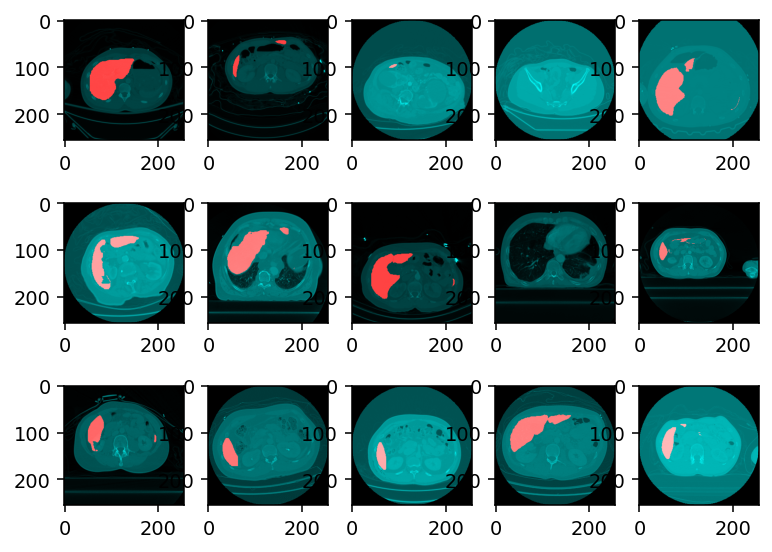

In [48]:

show_slice = 48#np.random.randint(0,VOLUME[0])
print("showing slice",show_slice)
for ii in range(15):
    show_id = np.random.randint(0,len(train_dataset))
    show_img = train_dataset[show_id][1][show_slice]
    print(show_img.shape)
    show_mask = show_img[1] # can be choose from 1 - 5
    show_jpg = show_img[0]
    axs = plt.subplot(3,5,ii+1);#axs.set_figheight(15)
    plt.imshow(np.stack([show_mask,show_jpg,show_jpg],axis=2).clip(0,255).astype(np.float32))

In [39]:
from tqdm import tqdm

In [49]:
torch.cuda.empty_cache()

In [50]:
os.path.exists(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{0}_fold{0}_{3}labels_{version}.pth')

False

In [ ]:
from datetime import datetime

train_loader = torch.utils.data.DataLoader(TrainDataset(trn_df), batch_size=1, shuffle=True, num_workers=0, drop_last=True)
# valid_loader = torch.utils.data.DataLoader(TrainDataset(val_df), batch_size=4, shuffle=True, num_workers=0, drop_last=True)

def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (sid, input, target) in enumerate(train_loader):
        if i %100 == 0 and i !=0:
            print(datetime.now(), f"epoch{epoch}",i, len(train_loader), train_loss / i)
            print(input.shape, target.shape)
            fw = open(log_path,'a')
            fw.write(" ".join([str(x) for x in ["train", f"epoch{epoch}", datetime.now(), \
                    i, len(train_loader), train_loss / i,input.shape, target.shape]])+"\n")
            fw.close()
        input = input.cuda()
        target = target.cuda()
        # print(input.shape)
        # compute output

        output = model(input)
        print(input.shape,target.shape,output.shape)
        # print(output.shape, target.shape)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        train_loss += loss.item()
        torch.cuda.empty_cache()
    return train_loss/len(train_loader)

pos_weights = {"lkidney":[1,2],"rkidney":[1,2],"kidney":[1,2,4],"bowel":[1,4,1,4],\
               "liver":[1,2,4],"spleen":[1,2,4],"all":[1,2,1,6,1,2,4,1,2,4,1,2,4,6]}

pos_weight = torch.Tensor([1,6,1,2,1,2,4,1,2,4,1,2,4]).cuda()
# pos_weight = torch.Tensor(pos_weights[organ_name]).cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)#pos_weight=pos_weight)
optimizer = torch.optim.SGD(model.parameters(), 0.0001)
model_name = f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{999}_fold{0}_{len(TARGET_COLS)}labels_6ch_{version}.pth'
print(model_name)
log_path = model_name.replace(".pth",".txt")
# model.load_state_dict(torch.load(f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_ep{0}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth'))
if not os.path.exists(log_path):
    fw = open(log_path,'w')

for epoch in range(1,5):
    train_loss = train(train_loader, model, criterion, optimizer)
    
    torch.save(model.state_dict(), model_name.replace("999",str(epoch)))
    # val_loss = validate(valid_loader, model, criterion)

In [52]:
for col in TARGET_COLS:
    print(col, np.sum(val_df[col].values))

bowel_healthy 870
bowel_injury 20
extravasation_healthy 847
extravasation_injury 43
kidney_healthy 848
kidney_low 27
kidney_high 15
liver_healthy 817
liver_low 55
liver_high 18
spleen_healthy 803
spleen_low 56
spleen_high 31


In [57]:

def validate(val_loader, model, criterion):
    model.eval()
    val_loss = 0.0
    
    val_pred = []
    val_label = []
    with torch.no_grad():
        for i, (sid, input, target) in enumerate(val_loader):
            if i %50 == 0 and i !=0:
                print(datetime.now(), i, len(val_loader), val_loss / i)
                print(input.shape)
                fw = open(log_path,'a')
                fw.write(" ".join([str(x) for x in ["valid", f"epoch{epoch}", datetime.now(), \
                        i, len(val_loader), val_loss / i,input.shape, target.shape]])+"\n")
                fw.close()
            input = input.cuda()
            target = target.cuda()
            output = model(input)
            val_loss += criterion(output, target)
            print(torch.sigmoid(output),target)
            output = torch.sigmoid(output)
            val_pred.append(output.data.cpu().numpy())
            val_label.append(target.data.cpu().numpy())
    return val_loss / len(val_loader.dataset), val_pred, val_label
model.load_state_dict(torch.load(f'./models/resnet18LSTM/resnet18_all_128_256_256_ep1_fold0_13labels_6ch_1010bal.pth'))


<All keys matched successfully>

In [58]:
valid_loader = torch.utils.data.DataLoader(TrainDataset(val_df), batch_size=4, shuffle=True, num_workers=0, drop_last=True)

val_loss = validate(valid_loader, model, criterion)

loading 11044 37630
loading 21782 36705
loading 16776 23671
loading 1027 24515
tensor([[0.9393, 0.1948, 0.8944, 0.1837, 0.8927, 0.1211, 0.1351, 0.8494, 0.2136,
         0.1060, 0.8050, 0.2252, 0.2462],
        [0.9419, 0.1882, 0.9003, 0.1656, 0.9060, 0.1130, 0.1064, 0.8565, 0.2062,
         0.0961, 0.8205, 0.2044, 0.2309],
        [0.9431, 0.1857, 0.8996, 0.1751, 0.8991, 0.1150, 0.1146, 0.8539, 0.2128,
         0.0976, 0.8176, 0.1957, 0.2241],
        [0.9453, 0.1743, 0.9046, 0.1649, 0.9094, 0.1123, 0.1068, 0.8606, 0.2063,
         0.0948, 0.8371, 0.1828, 0.2120]], device='cuda:0') tensor([[1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]], device='cuda:0')
loading 16914 59379
loading 17774 44435
loading 17326 4617
loading 16135 2438
tensor([[0.9386, 0.1861, 0.8951, 0.1668, 0.9027, 0.1140, 0.1074, 0.

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_128_256_256_ep{epoch}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
fw.close()

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_ep{epoch}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
torch.save(model.state_dict(), f'./models/resnet18LSTM/resnet18_{organ_name}_ep{2}_fold{0}_{len(TARGET_COLS)}labels_{version}.pth')

In [ ]:
pd.read_csv('submission.csv')